In [70]:
import gdown
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

- gpu 할당

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 데이터 적제

In [ ]:
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
fname = 'plant-pathology.zip'
gdown.download(url, fname, quiet=False)
!unzip plant-pathology.zip -d plant-pathology/

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [67]:
df_train = pd.read_csv('/content/plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [68]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3
df_train['label'] = df_train['label'].apply(lambda x : int(x))
df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [69]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [95]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))

    
    return img_path_list

In [96]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [100]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[0:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환

In [101]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
import cv2

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [105]:
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [106]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# 이미지 간단하게 텐서 변경(나중에 추가 예정)

In [125]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor()) 
train_loader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers=0) 
val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor()) 
vali_loader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers=0)

In [127]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

43 15
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


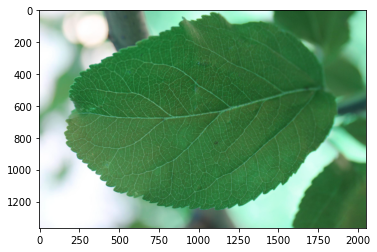

Label: 0


In [134]:
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")